In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/LiyuanLucasLiu/RAdam.git

In [ ]:
!unzip ./drive/My\ Drive/cifar.zip

In [0]:
import torch
import torchvision

In [0]:
import glob
import os

In [0]:
from RAdam.radam import RAdam

In [7]:
train_imgs = glob.glob('./cifar/train/*.png')
test_imgs = glob.glob('./cifar/test/*.png')
classes = []
with open('./cifar/labels.txt','r') as f:
  classes = f.readlines()
class_to_idx_dict = {class_.replace("\n",""):idx for idx, class_ in enumerate(classes)}
class_to_idx_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [0]:
transform = {
    'train':torchvision.transforms.Compose([
                                            # torchvision.transforms.RandomResizedCrop(32),
                                            # torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [0]:
from PIL import Image

In [0]:
class CIFAR10Dataset(torch.utils.data.Dataset):
  def __init__(self, img_path, transform=None, mode='train',class_to_idx_dict=class_to_idx_dict):
    super(CIFAR10Dataset, self).__init__()
    self.img_path = img_path
    self.transform = transform
    self.mode = mode
    self.class_to_idx_dict = class_to_idx_dict

  def __getitem__(self, idx):
    img_p = self.img_path[idx]
    img = Image.open(img_p)
    label = img_p.split('/')[-1].split('_')[-1].replace('.png','')
    label_idx = self.class_to_idx_dict[label]

    if self.transform:
      img = self.transform[self.mode](img)

    return img, label_idx

  def __len__(self):
    return len(self.img_path)

In [0]:
train_ds = CIFAR10Dataset(train_imgs, transform=transform,mode='train',class_to_idx_dict=class_to_idx_dict)
test_ds = CIFAR10Dataset(test_imgs, transform=transform, mode='test',class_to_idx_dict=class_to_idx_dict)

In [0]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)
dl_dict = {'train':train_dl,'test':test_dl}

In [0]:
criterion = torch.nn.CrossEntropyLoss()

In [0]:
epoch_num=100

In [0]:
hist = {"train_loss":[],"train_acc":[], "test_loss":[],"test_acc":[]}

In [ ]:
net = EfficientNet.from_pretrained('efficientnet-b1')
net._fc = torch.nn.Linear(in_features=net._bn1.num_features,out_features=num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = RAdam(net.parameters(),lr=1e-3,betas=(0.9,0.999))

device = "cuda:0" if torch.cuda.is_available else "cpu"
net.to(device)
torch.backends.cudnn.benchmark=True

In [ ]:
optimizer = RAdam(radam_en.parameters(),lr=1e-3,betas=(0.9,0.999))
print("START")
for epoch in range(52,epochs_num):
    radam_en.train()
    epoch_loss = 0.
    epoch_correct = 0.
    epoch_imgs = 0
    for i,batch in enumerate(train_dl):
        #print(i+1)
        imgs,labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        epoch_imgs += len(labels)
        optimizer.zero_grad()
        output = radam_en(imgs)
        loss = criterion(output, labels)        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss
        epoch_correct += sum(output.argmax(1)==labels)

    t_l = epoch_loss/(i+1)
    t_a = epoch_correct/epoch_imgs
    radam_hist['train_loss'].append(t_l)
    radam_hist['train_acc'].append(t_a)
    print("Epoch {}: Loss: {} Acc: {}".format(epoch,t_l,t_a)) 

    radam_en.eval()
    val_loss = 0.
    val_correct = 0.
    val_imgs = 0
    with torch.no_grad():
      for i,batch in enumerate(test_dl):
          imgs,labels = batch
          imgs = imgs.to(device)
          labels = labels.to(device)
          val_imgs += len(labels)
          output = radam_en(imgs)
          loss = criterion(output, labels)        
          
          val_loss += loss
          val_correct += sum(output.argmax(1)==labels) 

    l = val_loss/(i+1)
    a = val_correct/val_imgs
    radam_hist['test_loss'].append(l)
    radam_hist['test_acc'].append(a)
    print("Val: Loss: {} Acc: {}".format(l,a)) 

In [ ]:
radam_en = net
radam_hist = hist

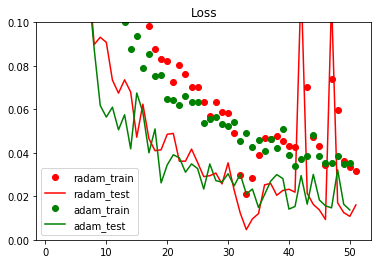

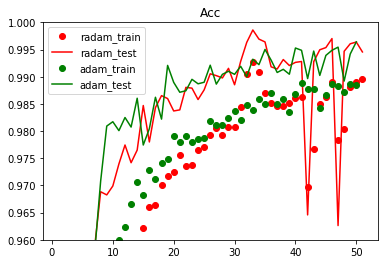

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

repochs = range(1, epochs_num+2)
epochs =range(1,epochs_num+1)

plt.title('Loss')
plt.plot(repochs, radam_hist['train_loss'],'ro',label='radam_train')
plt.plot(repochs, radam_hist['test_loss'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_loss'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_loss'],'g',label='adam_test')
plt.ylim((0.0,0.1))
plt.legend()

plt.figure()
plt.title('Acc')
plt.plot(repochs, radam_hist['train_acc'],'ro',label='radam_train')
plt.plot(repochs, radam_hist['test_acc'],'r',label='radam_test')
plt.plot(epochs, adam_hist['train_acc'],'go',label='adam_train')
plt.plot(epochs, adam_hist['test_acc'],'g',label='adam_test')
plt.ylim((0.96,1.0))
plt.legend()

## Discussion
Model: EfficientNet
**RAdam seems to be beaten by Adam** (Can't see the improvement...)

Possible Causes:  

1. Pretrained Model? -> RAdam assumes initial weights as $w_0 \sim \mathcal{N}(0,I)$
2. EfficientNet is too good at CIFAR-10 by default. -> Try another model

Experiments:

1. Train a model with $w_0 \sim \mathcal{N}(0,I)$
2. Try ResNet-50

Results:

1. 
2. 